In [2]:
import sys
sys.path.append('../../../src')
from image_quantification import *
from helpers import *
%matplotlib notebook

In [6]:
path = data_path + 'Imaging/RING PH'
paths = direcslist(path, 1)
lines = [p.strip('/').split('/')[-2].split('_')[1] for p in paths]
conditions = [p.strip('/').split('/')[-2].split('_')[2] for p in paths]

imgs = [load_image(p + '/af_corrected.tif') for p in paths]
rois = [np.loadtxt(p + '/ROI_fit.txt') for p in paths]

membg = np.loadtxt('../Quantification model calibration/membg6.txt')
cytbg = np.loadtxt('../Quantification model calibration/cytbg.txt')
calibration_factor = np.loadtxt('../Quantification model calibration/optogenetics_factors.txt')[6]
print(calibration_factor)

3.1058749583500798


100%|██████████| 600/600 [00:08<00:00, 74.18it/s]


<IPython.core.display.Javascript object>


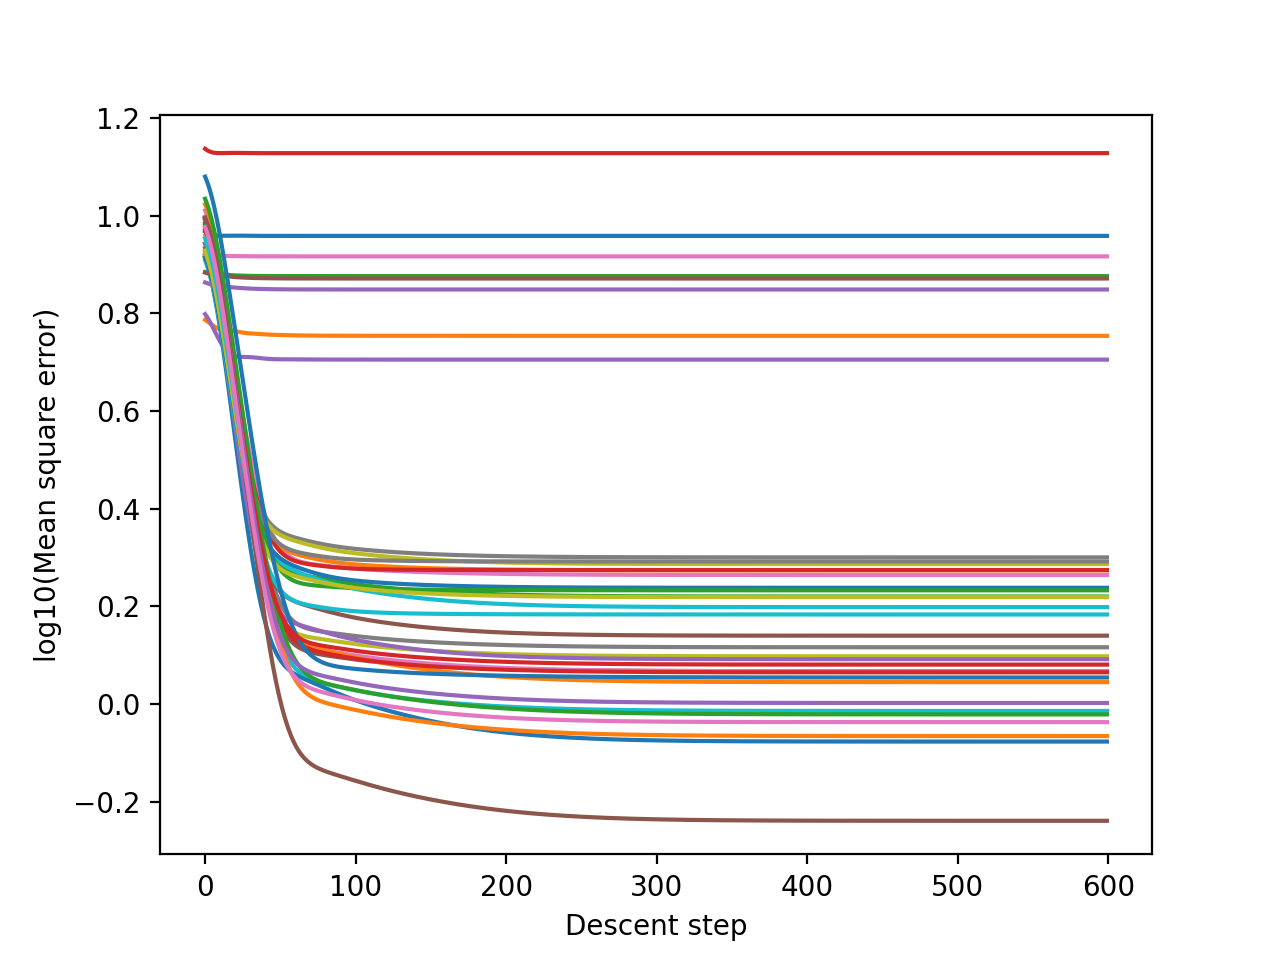

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

In [10]:
iq = ImageQuant2(img=imgs, roi=rois, cytbg=cytbg, membg=membg, pooling_rate=1, rol_ave=5, nfits=100)
iq.quantify()
iq.plot_losses(log=True)

<IPython.core.display.Javascript object>


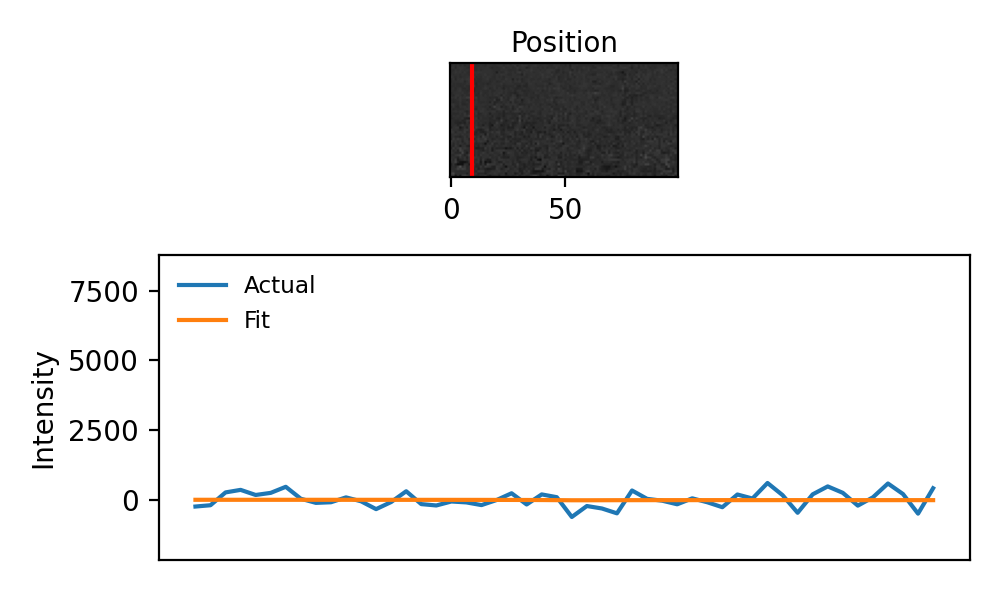

interactive(children=(IntSlider(value=0, description='Frame', max=36), FloatSlider(value=0.1, description='Pos…

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [11]:
iq.plot_fits()

<IPython.core.display.Javascript object>


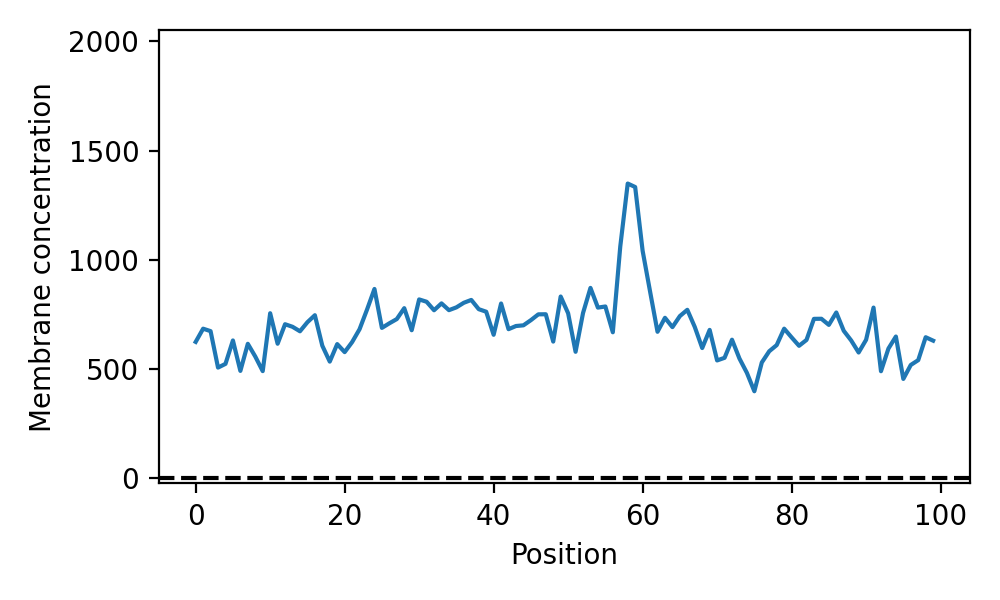

interactive(children=(IntSlider(value=0, description='Frame', max=36), Output()), _dom_classes=('widget-intera…

(<Figure size 500x300 with 1 Axes>,
 <AxesSubplot:xlabel='Position', ylabel='Membrane concentration'>)

In [12]:
iq.plot_quantification()

In [13]:
res = iq.compile_res()
res['Membrane signal'] *= calibration_factor
res.to_csv('res.csv')

In [14]:
res = pd.read_csv('res.csv')
cyts = res.groupby('EmbryoID').apply(lambda x: np.mean(x['Cytoplasmic signal']))
mems_tot = res.groupby('EmbryoID').apply(lambda x: np.mean(x['Membrane signal'])) 
mems_ant = res.groupby('EmbryoID').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.25, 0.75))) 
mems_post = res.groupby('EmbryoID').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.75, 0.25))) 
asis = [(p - a) / (a + p) for a, p in zip(mems_ant, mems_post)]
dosages = [dosage(i, r, 5) for i, r in zip(imgs, rois)]
totals = cyts + 0.174 * mems_tot
   
df_dict = {'Path': paths, 'Line': lines, 'Condition': conditions, 'Cyt': cyts, 'Mem_tot': mems_tot, 
           'Mem_ant': mems_ant, 'Mem_post': mems_post, 'ASI': asis, 'Dosage': dosages, 'Total': totals}
df = pd.DataFrame(df_dict)
df.to_csv('df.csv')

### Remove polar body

<IPython.core.display.Javascript object>


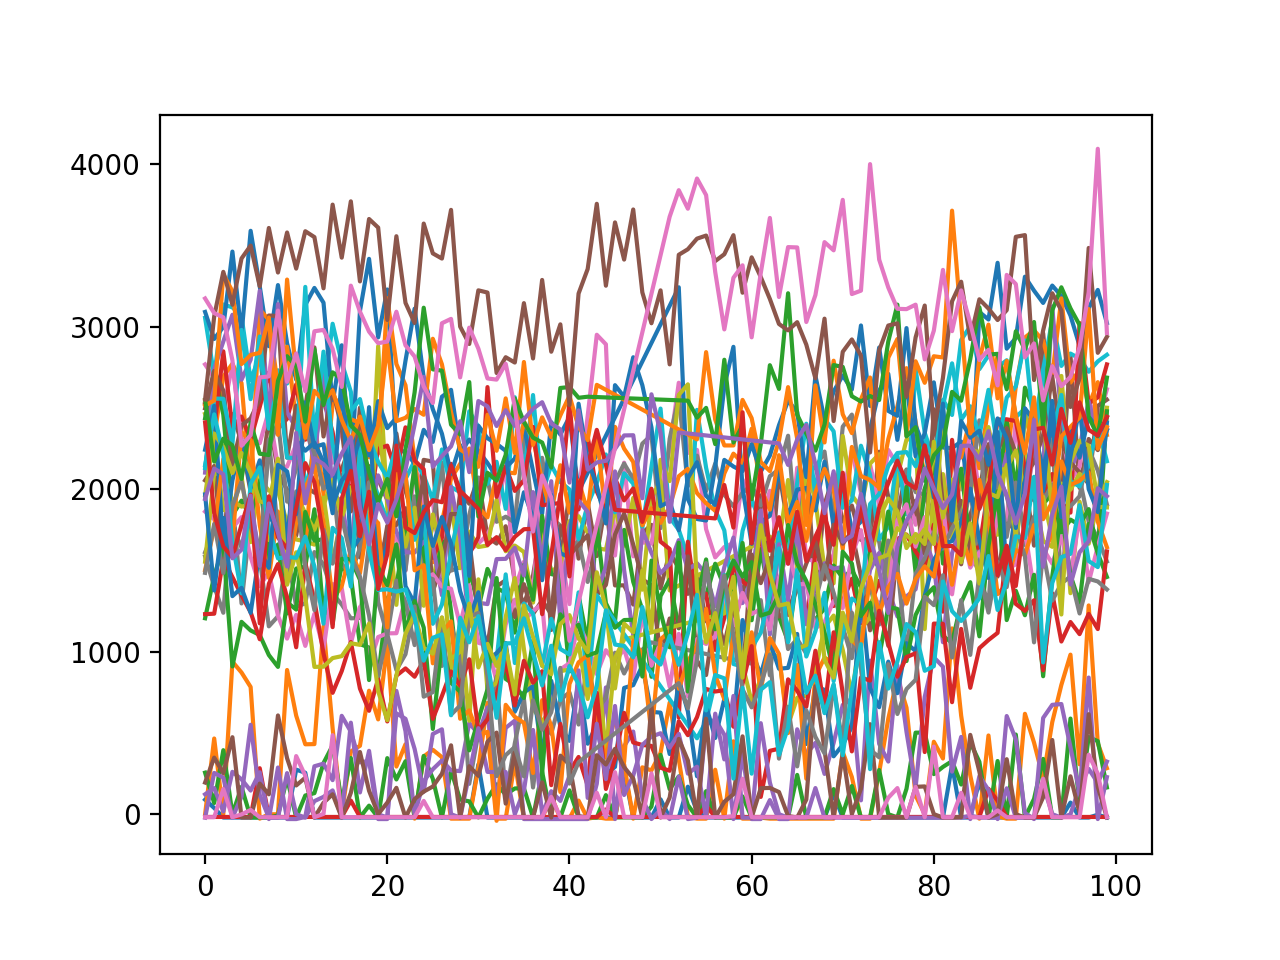

In [15]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

fig, ax = plt.subplots()
res = pd.read_csv('res.csv')
res_grouped = res.groupby('EmbryoID')
for (g, r), p, roi in zip(res_grouped, paths, rois):
    _mems = r['Membrane signal']
    mems = _mems.to_numpy()
    if os.path.exists(p + '/polar_body.txt'):
        polar_body = np.loadtxt(p + '/polar_body.txt')
        ind = int(100 * np.argmin(np.linalg.norm(roi - polar_body, axis=1)) / roi.shape[0])
        mems[ind-5:ind+5] = np.nan
        nans, x= nan_helper(mems)
        mems[nans] = np.interp(x(nans), x(~nans), mems[~nans])  
    ax.plot(mems)
    res.loc[_mems.index, 'Membrane signal'] = mems
res.to_csv('res_no_pb.csv')

In [16]:
res = pd.read_csv('res_no_pb.csv')
cyts = res.groupby('EmbryoID').apply(lambda x: np.mean(x['Cytoplasmic signal']))
mems_tot = res.groupby('EmbryoID').apply(lambda x: np.mean(x['Membrane signal'])) 
mems_ant = res.groupby('EmbryoID').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.25, 0.75))) 
mems_post = res.groupby('EmbryoID').apply(lambda x: bounded_mean_1d(x['Membrane signal'], (0.75, 0.25))) 
asis = [(p - a) / (a + p) for a, p in zip(mems_ant, mems_post)]
dosages = [dosage(i, r, 5) for i, r in zip(imgs, rois)]
totals = cyts + 0.174 * mems_tot
   
df_dict = {'Path': paths, 'Line': lines, 'Condition': conditions, 'Cyt': cyts, 'Mem_tot': mems_tot, 
           'Mem_ant': mems_ant, 'Mem_post': mems_post, 'ASI': asis, 'Dosage': dosages, 'Total': totals}
df = pd.DataFrame(df_dict)
df.to_csv('df_no_pb.csv')